# Example 8: Analyzing the Results of an NPTFit Run

While the chain samples of a non-Poissonian fit performed using MultiNest can be readily accessed, we provide a basic analysis module, `dnds_analysis.py` that contains helper functions to:
1. Make triangle plots;
2. Get template intensities;
3. Plot source count distributions;
4. Plot flux fractions;
5. Access individual posteriors; and
6. Get Bayesian log-evidences.

In this example we provide the details of how to use each function.

**NB:** Example 7 must be run before this notebook. Note that the run performed there was with a low nside and a fixed diffuse model, so the results below should be interpreted only as approximate.

In [1]:
# Import relevant modules

%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import corner
import matplotlib.pyplot as plt
from matplotlib import rcParams

import sys
sys.path.append("../NPTFit/")
import nptfit # module for performing scan
import create_mask as cm # module for creating the mask
import dnds_analysis # module for analysing the output
import psf_correction as pc # module for determining the PSF correction

In [2]:
# Set plotting options
rcParams['xtick.labelsize'] = 20
rcParams['ytick.labelsize'] = 20
rcParams['axes.labelsize'] = 20
rcParams['axes.titlesize'] = 20
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'CMU Serif'
rcParams['figure.figsize'] = (7,5)
rcParams['legend.fontsize'] = 16
rcParams['lines.linewidth'] = 1.5
# rcParams['text.usetex'] = True

## Analysis

At the outset, an instance of `nptfit.NPTF` must be created as was done when initiating and performing the scan. The process here is the same as in Example 7, up to configuring the scan. Finally, the scan is loaded with `n.load_scan()`.

In [3]:
n = nptfit.NPTF(tag='GCE_Example')

In [4]:
fermi_data = np.load('fermi_data/fermidata_counts.npy')
fermi_exposure = np.load('fermi_data/fermidata_exposure.npy')
n.load_data(fermi_data, fermi_exposure)

In [5]:
pscmask=np.array(np.load('fermi_data/fermidata_pscmask.npy'), dtype=bool)
analysis_mask = cm.make_mask_total(band_mask = True, band_mask_range = 2,
                                   mask_ring = True, inner = 0, outer = 30,
                                   custom_mask = pscmask)
n.load_mask(analysis_mask)

In [6]:
dif = np.load('fermi_data/template_dif.npy')
iso = np.load('fermi_data/template_iso.npy')
bub = np.load('fermi_data/template_bub.npy')
gce = np.load('fermi_data/template_gce.npy')
dsk = np.load('fermi_data/template_dsk.npy')

n.add_template(dif, 'dif')
n.add_template(iso, 'iso')
n.add_template(bub, 'bub')
n.add_template(gce, 'gce')
n.add_template(dsk, 'dsk')

In [7]:
n.add_poiss_model('iso','$A_\mathrm{iso}$',[-2,2],False)
n.add_poiss_model('dif','$A_\mathrm{dif}$',[-2,2],fixed=True, fixed_norm=15.)
n.add_poiss_model('gce','$A_\mathrm{gce}$',[-2,2],False)
n.add_poiss_model('bub','$A_\mathrm{bub}$',[-2,2],False)

In [8]:
n.add_non_poiss_model('gce',
                      ['$A_\mathrm{gce}^\mathrm{ps}$','$n_1^\mathrm{gce}$','$n_2^\mathrm{gce}$','$S_b^{(1), \mathrm{gce}}$'],
                      [[-6,1],[2.05,30],[-2,1.95],[0.05,40]],
                      [True,False,False,False])
n.add_non_poiss_model('dsk',
                      ['$A_\mathrm{dsk}^\mathrm{ps}$','$n_1^\mathrm{dsk}$','$n_2^\mathrm{dsk}$','$S_b^{(1), \mathrm{dsk}}$'],
                      [[-6,1],[2.05,30],[-2,1.95],[0.05,40]],
                      [True,False,False,False])

In [9]:
pc_inst = pc.psf_correction(psf_sigma_deg=0.1812)
f_ary, df_rho_div_f_ary = pc_inst.f_ary, pc_inst.df_rho_div_f_ary

Loading the psf correction from: /group/hepheno/smsharma/NPTFit/examples/psf_dir/gauss_128_0.181_10_50000_1000_0.01.npy


In [10]:
n.configure_for_scan(f_ary, df_rho_div_f_ary, nexp=1)

The number of parameters to be fit is 11


Finally, instead of running the scan we simply load the completed scan performed in Example 7.

In [11]:
n.load_scan()

  analysing data from /group/hepheno/smsharma/NPTFit/examples/chains/GCE_Example/.txt


## Analysis

An instance of `nptf.NPTF` with a loaded scan as above can already be used to access the posterior chains with `n.samples`:

In [12]:
print np.shape(n.samples)
print n.samples

(715, 11)
[[  2.02183174e-01   2.39669575e-02   9.79958092e-01 ...,   2.21879127e+01
    4.13248782e-01   3.89056680e+01]
 [  1.42877959e-01   1.67586387e-02   9.18143440e-01 ...,   2.39770745e+00
    1.10613478e+00   2.82342018e+01]
 [  3.13657173e-01   3.40163197e-02   9.70377300e-01 ...,   2.06343720e+00
    1.44329031e+00   2.27620469e+01]
 ..., 
 [  3.11079740e-01   1.02820464e-02   9.18678453e-01 ...,   2.35394791e+00
   -3.42663799e-01   2.52508167e+01]
 [  3.11079740e-01   1.02820464e-02   9.18678453e-01 ...,   2.35394791e+00
   -3.42663799e-01   2.52508167e+01]
 [  3.83860007e-01   1.06242110e-02   8.70613582e-01 ...,   2.23894317e+00
   -7.75741149e-01   2.91286566e+01]]


In the analysis module described next we provide basic helper functions to load in and manipulate these chain samples.

### 0. Initialize Analysis Module

The first thing to do is initialize an instance of the analysis module, `dnds_analysis` from `dnds_analysis.py` with a provided instance of `nptfit.NPTF`. The `NPTF` instance should have a scan already loaded in, as done with `n.load_scan()` above.

In [13]:
an = dnds_analysis.dnds_analysis(n)

`dnds_analysis` has an optional argument `mask`, which if unset defaults to the mask in the passed instance of `NPTF`. If a mask is given, however, then the analysis will be performed in a different ROI to the main run.

### 1. Make triangle plots

Triangle/corner plots let us visualize multidimensional samples using a scatterplot matrix. A triangle plot with the default options can be made as follows.

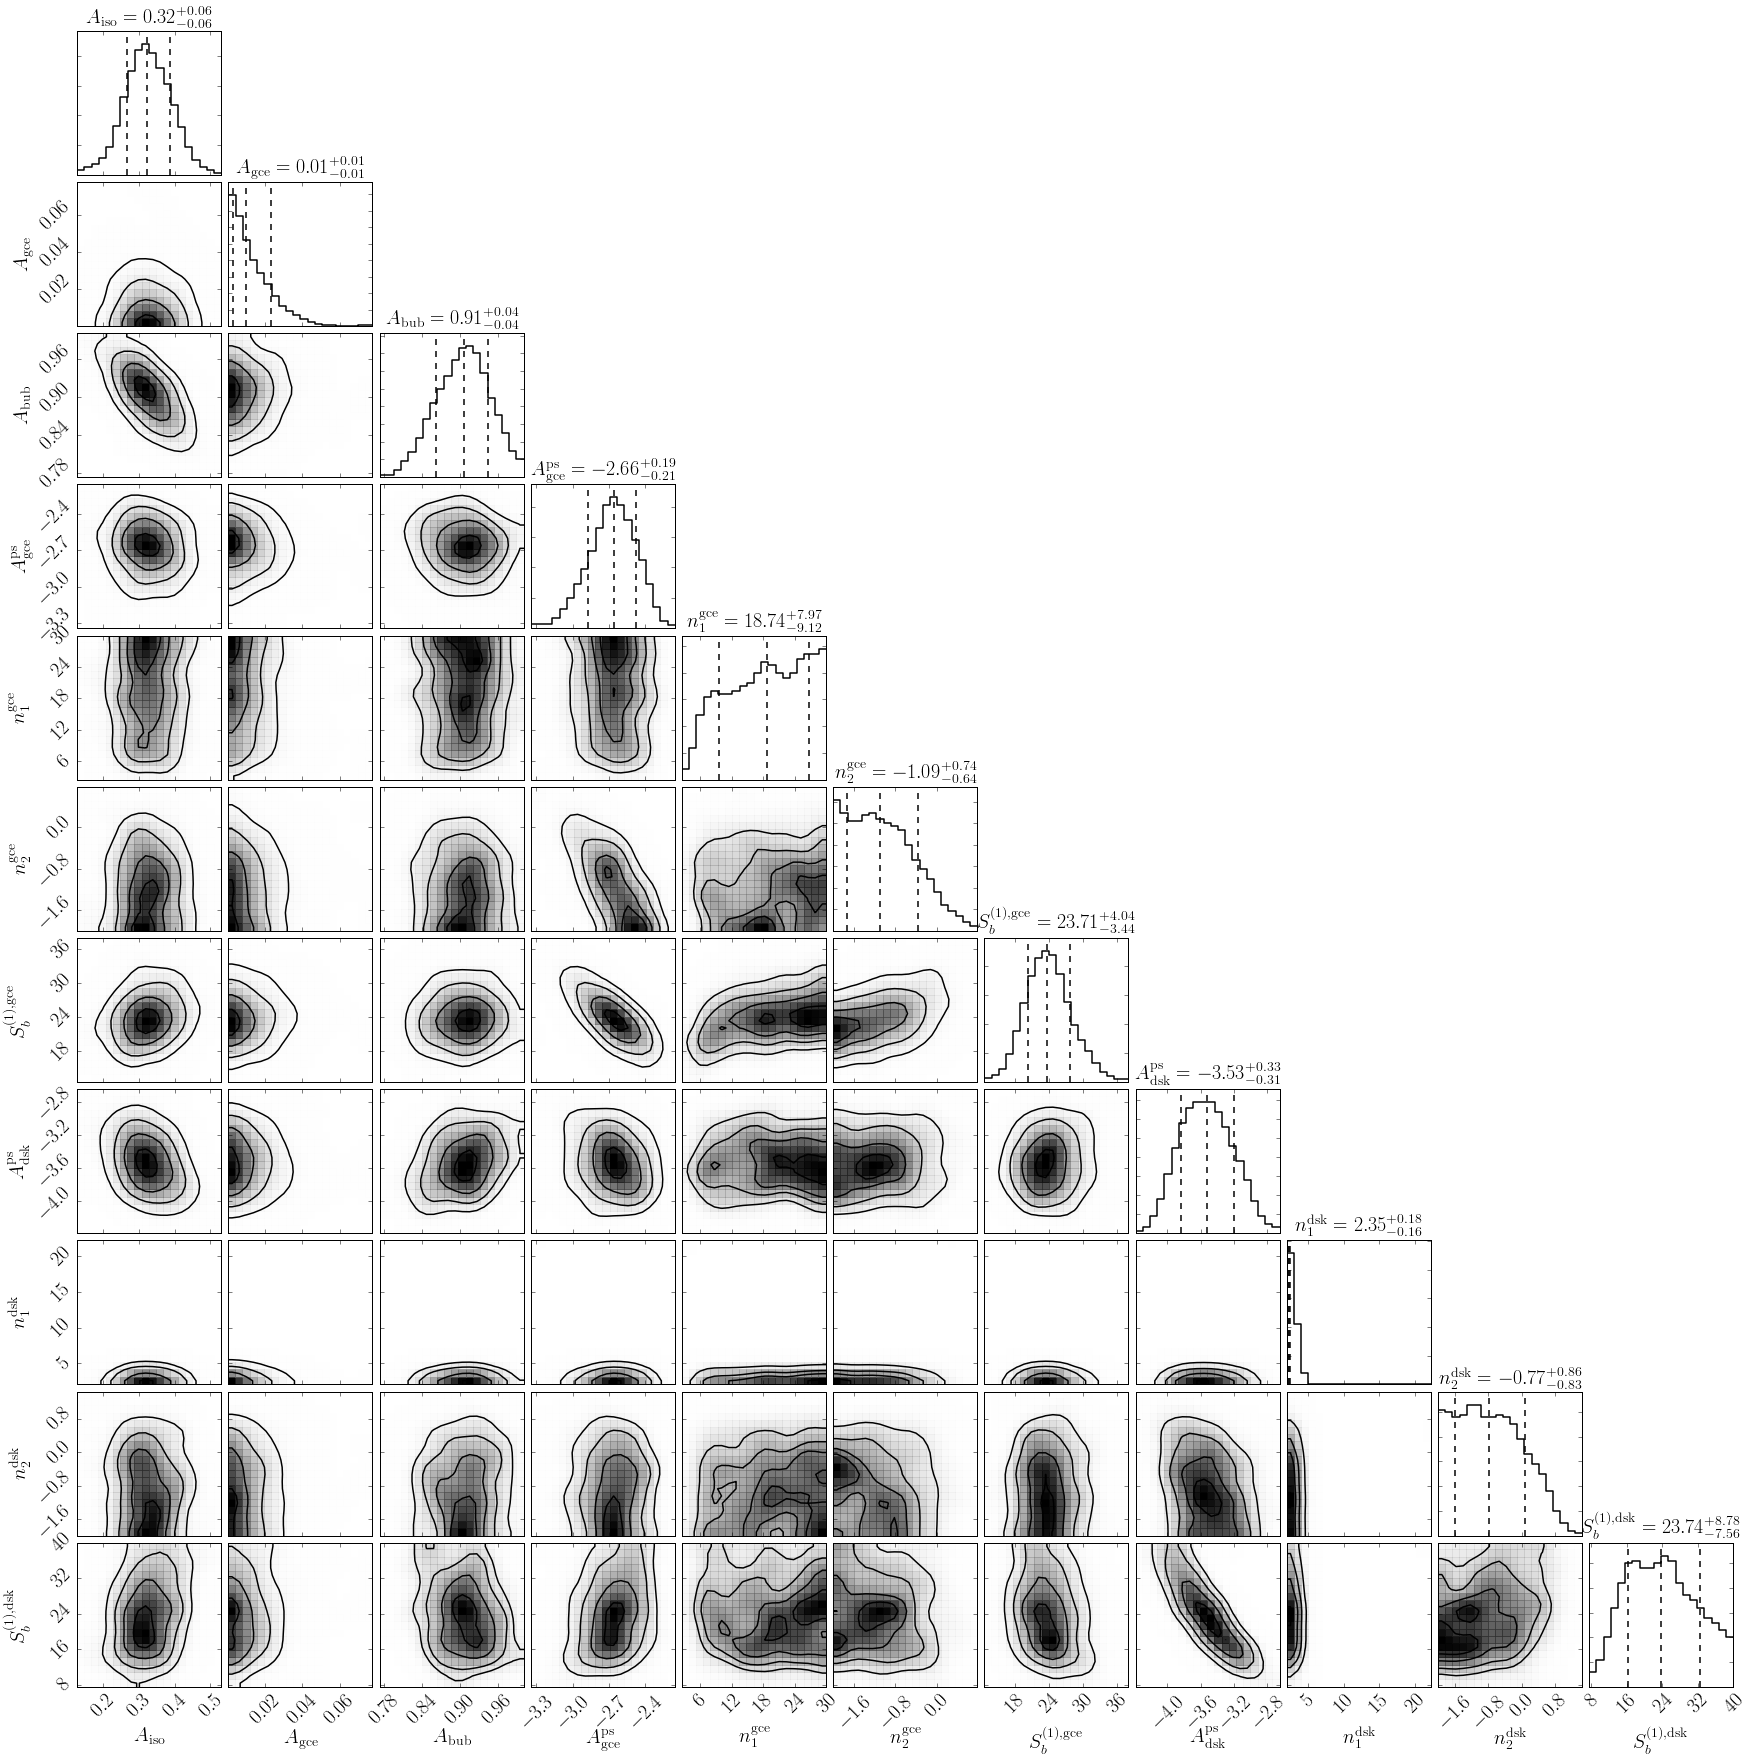

In [14]:
an.make_triangle()

To use your own custom plotting options, use corner as follows

```python
corner.corner(an.nptf.samples, labels=an.nptf.params, range=[1 for i in range(an.nptf.n_params)])
```
with additional arguments as specified in http://corner.readthedocs.io/en/latest/.

### 2. Get Intensities

Template intensities can be calculated with 
```python
dnds_analysis.return_intensity_arrays_poiss(comp)
dnds_analysis.return_intensity_arrays_non_poiss(comp)
```
for the Poissonian and non-Poissonian templates respectively. This returns an intensity array corresponding to each chain sample associated with the template `comp`. 

The NPT intensity is calculated by integrating up $\int_{S_{min}}^{S_{max}} dS~S~dN/dS$. This is approximated as a sum between $S_{min}$ and $S_{max}$. The options associated with the non-Poissonian template intensity are:

| Argument  | Default Value | Purpose |
| ------------- | ------------- | ------------- |
| `comp`  | - | The NPT key |
| `smin`  | 0.01 | Minimum counts to sum up from  |
| `smax`  | 10000 | Maximum counts to sum up to |
| `nsteps`  | 10000 | Number of bins in `s` while summing up  |

We can then look at the quantiles of this distribution, for example to see the middle 68% along with the medians of the GCE and disk NPT as well as that of the GCE PT:

In [15]:
print "GCE NPT Intensity", corner.quantile(an.return_intensity_arrays_non_poiss('gce'),[0.16,0.5,0.84]), "ph/cm^2/s"
print "Disk NPT Intensity", corner.quantile(an.return_intensity_arrays_non_poiss('dsk'),[0.16,0.5,0.84]), "ph/cm^2/s"
print "GCE PT Intensity", corner.quantile(an.return_intensity_arrays_poiss('gce'),[0.16,0.5,0.84]), "ph/cm^2/s"

GCE NPT Intensity [  9.74733669e-08   1.11380763e-07   1.22590855e-07] ph/cm^2/s
Disk NPT Intensity [  8.71555274e-08   1.01280005e-07   1.19953723e-07] ph/cm^2/s
GCE PT Intensity [  5.37910482e-10   2.13377720e-09   5.04887005e-09] ph/cm^2/s


### 3. Plot Source Count Distributions 

The posterior arrays for the source count distributions $dN/dF$ [counts$^{-1}$ cm$^2$ s deg$^{-2}$] associated with a given template `comp` at a given `flux` [counts/cm$^2$/s] can be obtained using 

```python
dnds.return_dndf_arrays(comp,flux)
```
The quantiles of this can then be obtained as before. For example, the middle 68% and medians for the GCE and disk non-Poissonian templates:

In [16]:
print corner.quantile(an.return_dNdF_arrays('gce',1e-12),[0.16,0.5,0.84])
print corner.quantile(an.return_dNdF_arrays('dsk',1e-12),[0.16,0.5,0.84])

[  4.85743498e+04   1.24615711e+06   6.26836117e+07]
[  1.40610459e+04   9.75809896e+05   1.69668804e+08]


The source count distribution can be plotted with 
```python
dnds.plot_source_count_median(comp, smin, smax, nsteps, spow, **kwargs)
dnds.plot_source_count_band(comp, smin, smax, nsteps, spow, qs, **kwargs)
```
The options being the same as for obtaining the NPT intensity above. Additionally, `spow` is the power $n$ in $F^ndN/dF$ to return while plotting, and `qs` is an array of quantiles for which to return the dN/dF band.

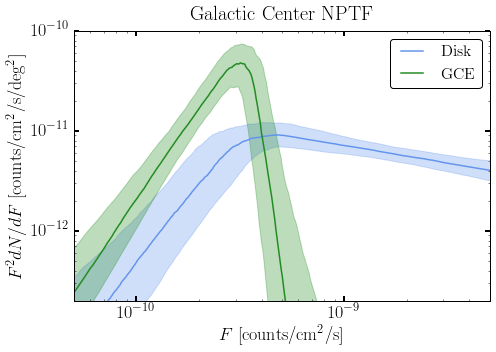

In [17]:
an.plot_source_count_median('dsk',smin=0.01,smax=1000,nsteps=1000,color='cornflowerblue',spow=2,label='Disk')
an.plot_source_count_band('dsk',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='cornflowerblue',alpha=0.3,spow=2)

an.plot_source_count_median('gce',smin=0.01,smax=1000,nsteps=1000,color='forestgreen',spow=2,label='GCE')
an.plot_source_count_band('gce',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='forestgreen',alpha=0.3,spow=2)

plt.yscale('log')
plt.xscale('log')
plt.xlim([5e-11,5e-9])
plt.ylim([2e-13,1e-10])
plt.tick_params(axis='x', length=5, width=2, labelsize=18)
plt.tick_params(axis='y', length=5, width=2, labelsize=18)
plt.ylabel('$F^2 dN/dF$ [counts/cm$^2$/s/deg$^2$]', fontsize=18)
plt.xlabel('$F$  [counts/cm$^2$/s]', fontsize=18)
plt.title('Galactic Center NPTF', y=1.02)
plt.legend(fancybox=True)
plt.tight_layout()
plt.savefig("GCE-NPTF-SourceCount.png")

As some references also show $dN/dF$ we give an example of it below, also demonstrating the use of `spow`.

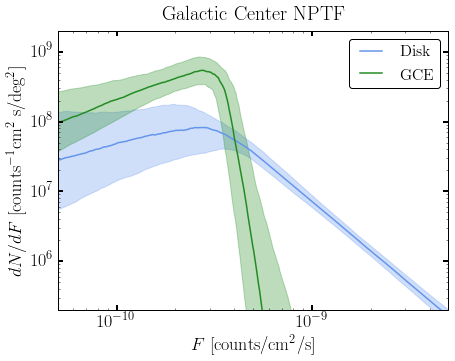

In [18]:
an.plot_source_count_median('dsk',smin=0.01,smax=1000,nsteps=1000,color='cornflowerblue',spow=0,label='Disk')
an.plot_source_count_band('dsk',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='cornflowerblue',alpha=0.3,spow=0)

an.plot_source_count_median('gce',smin=0.01,smax=1000,nsteps=1000,color='forestgreen',spow=0,label='GCE')
an.plot_source_count_band('gce',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='forestgreen',alpha=0.3,spow=0)

plt.yscale('log')
plt.xscale('log')
plt.xlim([5e-11,5e-9])
plt.ylim([2e5,2e9])
plt.tick_params(axis='x', length=5, width=2, labelsize=18)
plt.tick_params(axis='y', length=5, width=2, labelsize=18)
plt.ylabel('$dN/dF$ [counts$^{-1}$cm$^2$ s/deg$^2$]', fontsize=18)
plt.xlabel('$F$  [counts/cm$^2$/s]', fontsize=18)
plt.title('Galactic Center NPTF', y=1.02)
plt.legend(fancybox=True)

### 4. Plot Intensity Fractions

Intensity fractions (fraction of template intensity to total intensity) for Poissonian and non-Poissonian templates respectively can be plotting using
```python
dnds.plot_intensity_fraction_poiss(comp, bins, **kwargs)
dnds.plot_intensity_fraction_non_poiss(comp, bins, **kwargs)
```
where `comp` is the template key, `bins` is the number of bins between 0 and 100 and `**kwargs` specify plotting options.

(0, 6)

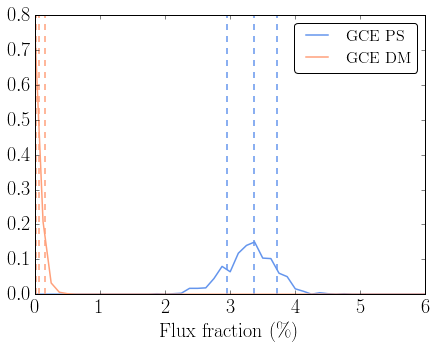

In [19]:
an.plot_intensity_fraction_non_poiss('gce', bins=800, color='cornflowerblue', label='GCE PS')
an.plot_intensity_fraction_poiss('gce', bins=800, color='lightsalmon', label='GCE DM')
plt.xlabel('Flux fraction (%)')
plt.legend(fancybox = True)
plt.xlim(0,6)

This plot makes it clear, that when given the choice, the fit prefers to put the GCE flux into point sources rather than diffuse emission.

### 5. Access Parameter Posteriors

While the posteriors can be accessed with `n.samples` (or `an.nptf.samples`) as above, the following functions provide a useful interfact to access individual parameters:

```python
dnds_analysis.return_poiss_parameter_posteriors(comp)
dnds_analysis.return_poiss_parameter_posteriors(comp)
```
where `comp` is the (non-)Poissonian template key.

#### Poissonian parameters

Posterior normalizations of Poissonian parameters can be loaded simply as:

In [20]:
Aiso_poiss_post = an.return_poiss_parameter_posteriors('iso')
Agce_poiss_post = an.return_poiss_parameter_posteriors('gce')
Abub_poiss_post = an.return_poiss_parameter_posteriors('bub')

These can then be use in any way required, for example simply plotted:

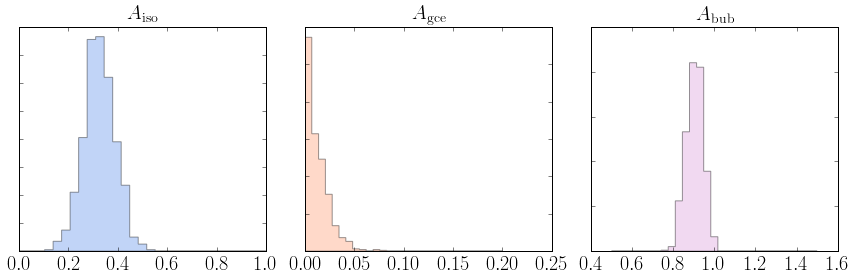

In [21]:
f, axarr = plt.subplots(nrows = 1, ncols=3)
f.set_figwidth(12)
f.set_figheight(4)

axarr[0].hist(Aiso_poiss_post, histtype='stepfilled', color='cornflowerblue', bins=np.linspace(0,1.,30), alpha=.4);
axarr[0].set_title('$A_\mathrm{iso}$')
axarr[1].hist(Agce_poiss_post, histtype='stepfilled', color='lightsalmon', bins=np.linspace(0,.2,30), alpha=.4);
axarr[1].set_title('$A_\mathrm{gce}$')
axarr[2].hist(Abub_poiss_post, histtype='stepfilled', color='plum', bins=np.linspace(.5,1.5,30), alpha=.4);
axarr[2].set_title('$A_\mathrm{bub}$')

plt.setp([a.get_yticklabels() for a in axarr], visible=False);

plt.tight_layout()

#### Non-poissonian parameters

A similar syntax can be used to extract the non-Poissonian parameters.

In [22]:
Agce_non_poiss_post, n_non_poiss_post, Sb_non_poiss_post = an.return_non_poiss_parameter_posteriors('gce')

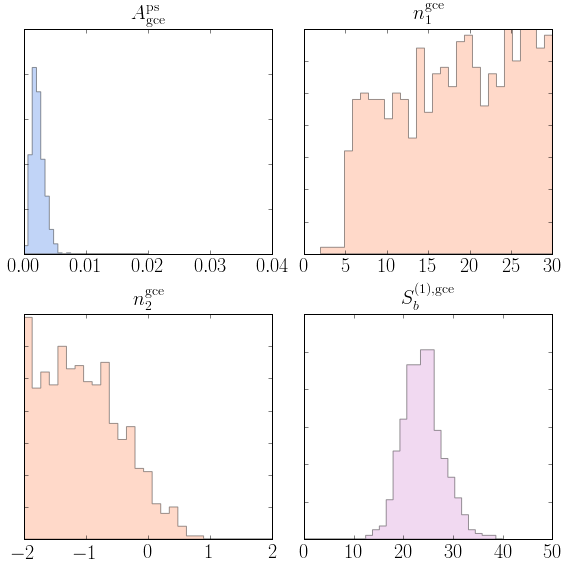

In [23]:
f, axarr = plt.subplots(2, 2);
f.set_figwidth(8)
f.set_figheight(8)


axarr[0, 0].hist(Agce_non_poiss_post, histtype='stepfilled', color='cornflowerblue', bins=np.linspace(0,0.02,30), alpha=.4);
axarr[0, 0].set_title('$A_\mathrm{gce}^\mathrm{ps}$')
axarr[0, 1].hist(n_non_poiss_post[0], histtype='stepfilled', color='lightsalmon', bins=np.linspace(2,30,30), alpha=.4);
axarr[0, 1].set_title('$n_1^\mathrm{gce}$')
axarr[1, 0].hist(n_non_poiss_post[1], histtype='stepfilled', color='lightsalmon', bins=np.linspace(-2,2,30), alpha=.4);
axarr[1, 0].set_title('$n_2^\mathrm{gce}$')
axarr[1, 1].hist(Sb_non_poiss_post, histtype='stepfilled', color='plum', bins=np.linspace(0,40,30), alpha=.4);
axarr[1, 1].set_title('$S_b^{(1), \mathrm{gce}}$')

plt.setp(axarr[0, 0], xticks=[x*0.01 for x in range(5)])
plt.setp(axarr[1, 0], xticks=[x*1.0-2 for x in range(5)])
plt.setp(axarr[1, 1], xticks=[x*10 for x in range(6)])
plt.setp([a.get_yticklabels() for a in axarr[:, 1]], visible=False);
plt.setp([a.get_yticklabels() for a in axarr[:, 0]], visible=False);

plt.tight_layout()

### 6. Bayesian log-evidence

Finally the Bayesian log-evidence and associated error can be accessed as follows.

In [24]:
lBE, lBE_error = an.get_log_evidence()
print lBE, lBE_error

-33479.166149 0.457762328977
